<a href="https://colab.research.google.com/github/hsivasub/NeuralStyleTransfer/blob/main/StyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.utils import save_image


In [2]:
model= models.vgg19(pretrained=True).features
model

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

Now we have to obtain the five conv layers and each conv layer consist of a pooling layer according to the article

In [3]:
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features=['0','5','10','19','28']  #These are five layers which we are interested in.
        self.model= models.vgg19(pretrained=True).features[:29]
        
    def forward(self,x):
        features=[]
        
        for layer_num, layer in enumerate(self.model):
            x=layer(x)
            
            if str(layer_num) in self.chosen_features:
                features.append(x)
        
        return features
            

In [4]:
device= torch.device('cuda' if torch.cuda.is_available else 'cpu')
print(device)
image_size=356

loader= transforms.Compose([
                    transforms.Resize((image_size,image_size)),
                     transforms.ToTensor()
                     ])

def load_image(image_name):
    image=Image.open(image_name)
    image= loader(image).unsqueeze(0)  #We are adding additional dimension for the batch size
    return image.to(device)



cuda


In [12]:
original_img= load_image('/content/cup.jpg')
style_img= load_image('/content/style.jpg')

#For initializing the Generated Image, it is better to copy the original image
generated= original_img.clone().requires_grad_(True)

In [13]:
#Hyper parameters
total_steps=6000
learning_rate=0.001
alpha=1  #Parameter for Content Loss
beta=0.01  #Parameter for the Style loss
optimizer= optim.Adam([generated], lr=learning_rate)

#Usually we sned in the model.paramters for the optimizer because thats what the model would optimize.
#But here we are optimizing the image and hence we give the generated image


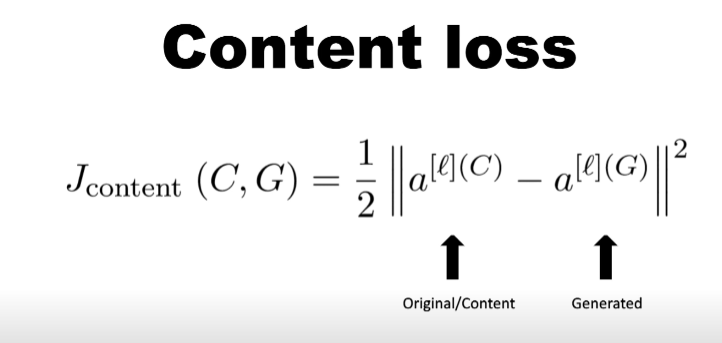

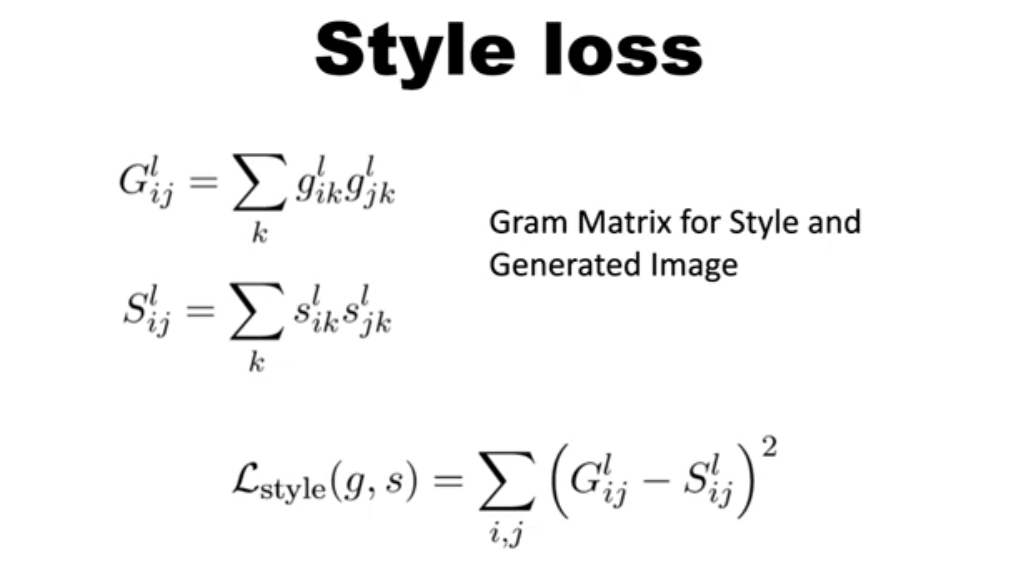

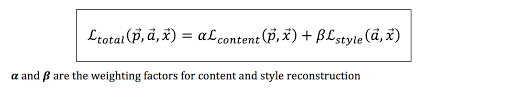

In [14]:
model= VGG().to(device).eval()   #Using eval() would freeze the weights as we want to update image and not the weights

In [15]:
for step in range(total_steps):
  generated_features= model(generated)
  original_img_features= model(original_img)
  style_features= model(style_img)

  style_loss= original_loss=0

  for gen_feature, orig_feature, style_feature in zip(generated_features,
                                                      original_img_features,
                                                      style_features):
    #This will loop through 5 Conv layers
    
    batch_size,channel, height, width= gen_feature.shape

    original_loss+= torch.mean((gen_feature- orig_feature)**2)

    #Compute the Gram Matrix

    G= gen_feature.view(channel,height*width).mm(  #mm is the matrix multiplication
        gen_feature.view(channel,height*width).t()  #This would get the transpose
    )

    A= style_feature.view(channel,height*width).mm(  #mm is the matrix multiplication
        style_feature.view(channel,height*width).t()  #This would get the transpose
    )

    style_loss+= torch.mean((G-A)**2)

  total_loss= (alpha*original_loss) + (beta*style_loss)
  optimizer.zero_grad()
  total_loss.backward()
  optimizer.step()

  if step % 1000==0:
    print('Total Loss value:',total_loss)
    save_image(generated, f'generated_{step}.png')


Total Loss value: tensor(2245193.5000, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss value: tensor(26709.2617, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss value: tensor(14793.1895, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss value: tensor(9328.2852, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss value: tensor(6153.4258, device='cuda:0', grad_fn=<AddBackward0>)
Total Loss value: tensor(4324.3872, device='cuda:0', grad_fn=<AddBackward0>)


In [16]:
len(generated_features)

5